In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
import os
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from sklearn import datasets
from keras.layers import Dense,MaxPooling1D,MaxPooling2D,Conv2D,Flatten, Dropout, LSTM, Activation,SimpleRNN,Bidirectional,Conv1D,InputLayer,GRU
import tensorflow as tf
from tensorflow import keras
from dataset import Dataset

2023-11-13 23:32:20.723799: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load Data

In [2]:
# CWD = os.getcwd()
# train_df = pd.read_csv(os.path.join(CWD,"train_data.csv"))
# test_df = pd.read_csv(os.path.join(CWD,"test_data.csv"))
# true_rul = pd.read_csv(os.path.join(CWD,"RUL_FD001.txt"),sep="\s+", header=None)

CWD = os.getcwd()
train_df = pd.read_csv(os.path.join(CWD,"train_data2.csv"))
test_df = pd.read_csv(os.path.join(CWD,"test_data2.csv"))
true_rul = pd.read_csv(os.path.join(CWD,"RUL_FD001.txt"),sep="\s+", header=None)

train_df.rename(columns={'id':'unit'},inplace=True)
test_df.rename(columns={'id':'unit'},inplace=True)
train_df.head()

,unit,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,-0.080460,-0.666667,-1.0,-1.0,-0.632530,-0.186396,-0.380486,-1.0,...,-1.0,-0.333333,-1.0,-1.0,0.426357,0.449323,191,0,0,-1.000000
1,1,2,0.218391,-0.500000,-1.0,-1.0,-0.433735,-0.093961,-0.294733,-1.0,...,-1.0,-0.333333,-1.0,-1.0,0.333333,0.462027,190,0,0,-0.994460
2,1,3,-0.494253,0.500000,-1.0,-1.0,-0.313253,-0.260955,-0.258947,-1.0,...,-1.0,-0.666667,-1.0,-1.0,0.255814,0.242751,189,0,0,-0.988920
3,1,4,0.080460,0.000000,-1.0,-1.0,-0.313253,-0.487683,-0.337610,-1.0,...,-1.0,-0.333333,-1.0,-1.0,0.147287,0.324772,188,0,0,-0.983380
4,1,5,-0.218391,-0.333333,-1.0,-1.0,-0.301205,-0.485066,-0.190749,-1.0,...,-1.0,-0.166667,-1.0,-1.0,0.178295,0.409003,187,0,0,-0.977839


In [3]:
true_rul.head()

,0
0,112
1,98
2,69
3,82
4,91


In [4]:
test_df.head()

,unit,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.264368,0.500000,-1.0,-1.0,0.090361,-0.378679,-0.461175,-1.0,...,-1.0,-0.333333,-1.0,-1.0,0.116279,0.323667,-1.000000,142,0,0
1,1,2,-0.310345,-0.500000,-1.0,-1.0,-0.698795,-0.240898,-0.555368,-1.0,...,-1.0,-0.166667,-1.0,-1.0,0.364341,0.373654,-0.994460,141,0,0
2,1,3,0.034483,0.166667,-1.0,-1.0,-0.246988,-0.306736,-0.355503,-1.0,...,-1.0,-0.166667,-1.0,-1.0,0.457364,0.442695,-0.988920,140,0,0
3,1,4,0.482759,0.000000,-1.0,-1.0,-0.259036,-0.429693,-0.183997,-1.0,...,-1.0,-0.500000,-1.0,-1.0,0.333333,0.324220,-0.983380,139,0,0
4,1,5,0.160920,0.000000,-1.0,-1.0,-0.216867,-0.295836,-0.335922,-1.0,...,-1.0,-0.666667,-1.0,-1.0,0.317829,0.432753,-0.977839,138,0,0


## 2. Modelling

### Function to Evaluate Model Metrics

In [5]:
def evaluateModel(y_true,y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return (mse,mae,rmse,r2)

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import xgboost
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor

lreg_model = LinearRegression()
forest_reg = RandomForestRegressor()
knr_model = KNeighborsRegressor(n_neighbors=12)
xgb_reg = xgboost.XGBRegressor()
svm_reg = SVR()
tree_reg = DecisionTreeRegressor()
ext_tree_reg = ExtraTreesRegressor()
ada_reg = AdaBoostRegressor()


In [7]:
# dataset_variations = ['all_columns','without_settings','without_constant_sensors','with_aggregates','aggregates_only']
dataset_variations = ['all_columns','without_settings','without_constant_sensors']
models = [{'lreg':lreg_model},{'knr':knr_model},{'forest':forest_reg},{'xgb':xgb_reg},{'svm_reg':svm_reg},{'decision_tree':tree_reg}
         ,{'extra_tree':ext_tree_reg},{'ada_reg':ada_reg}]

experiments = []
for dataset in dataset_variations:
    for model_dict in models:
        model_name, model_instance = list(model_dict.items())[0]
        experiments.append({'include_columns': dataset, 'model': {'name': model_name,'instance':model_instance}})

In [8]:
target_column = ['RUL']
to_exclude = ['unit','cycle','cycle_norm','label1','label2']
settings_cols = ['setting1','setting2','setting3']
constant_sensors = ['s1','s5','s6','s10','s16','s18','s19']

In [9]:
%%time

counter=1;
for experiment in experiments:
    print(f'Experiment {counter}/{len(experiments)}...')
    counter+=1
    
    include_columns = experiment['include_columns']
    columns = list(set(train_df.columns) - set(to_exclude))
    if(include_columns=='without_settings'): 
        to_exclude.extend(settings_cols)
        columns = list(set(train_df.columns) - set(to_exclude))
        
    elif (include_columns=='without_constant_sensors'):
        to_exclude.extend(settings_cols)
        to_exclude.extend(constant_sensors)
        columns = list(set(train_df.columns) - set(to_exclude))
        
    model_name = experiment['model']['name']
    model_instance = experiment['model']['instance']
    
    dataset = Dataset(train_df.copy())
    test_dataset = Dataset(test_df.copy())
    df = dataset.get(columns=columns)
    df2 = test_dataset.get(columns=columns)
    
    y_train = df[target_column]
    X_train = df.drop(columns=target_column,axis=1)
    
    y_test = df2[target_column]
    X_test = df2.drop(columns=target_column,axis=1)
    
    experiment['train_shape'] = X_train.shape
    
    model_instance.fit(X_train,y_train)
    predictions = model_instance.predict(X_train)
    
    # Calculate Cross-Validation Score
    cv_scores = cross_val_score(model_instance, X_train, y_train,scoring="neg_mean_squared_error", cv=10)
    cv_rmse_scores = np.sqrt(-cv_scores)
    experiment['cv-rmse'] = cv_rmse_scores.mean()
    experiment['cv-std'] = cv_rmse_scores.std()
    
    test_predictions = model_instance.predict(X_test)
    
    train_mse,train_mae,train_rmse,train_r2 = evaluateModel(y_train,predictions)
    test_mse,test_mae,test_rmse,test_r2 = evaluateModel(y_test,test_predictions)
    
    experiment['train_rmse']=train_rmse
    experiment['test_rmse']=test_rmse
    
    experiment['train_mse']=train_mse
    experiment['test_mse']=test_mse
    
    experiment['train_mae']=train_mae
    experiment['test_mae']=test_mae
    
    experiment['train_r2']=train_r2
    experiment['test_r2']=test_r2    

Experiment 1/24...
Experiment 2/24...
Experiment 3/24...
Experiment 4/24...
Experiment 5/24...
Experiment 6/24...
Experiment 7/24...
Experiment 8/24...
Experiment 9/24...
Experiment 10/24...
Experiment 11/24...
Experiment 12/24...
Experiment 13/24...
Experiment 14/24...
Experiment 15/24...
Experiment 16/24...
Experiment 17/24...
Experiment 18/24...
Experiment 19/24...
Experiment 20/24...
Experiment 21/24...
Experiment 22/24...
Experiment 23/24...
Experiment 24/24...
CPU times: user 39min 23s, sys: 31.1 s, total: 39min 54s
Wall time: 39min 51s


In [10]:
experiments_df = pd.DataFrame(experiments)
sorted_experiments_df = experiments_df.sort_values(by='train_rmse')
sorted_experiments_df = sorted_experiments_df.reset_index(drop=True)
sorted_experiments_df

,include_columns,model,train_shape,cv-rmse,cv-std,train_rmse,test_rmse,train_mse,test_mse,train_mae,test_mae,train_r2,test_r2
0,without_settings,"{'name': 'extra_tree', 'instance': (ExtraTreeR...","(20631, 21)",41.724374,10.390597,0.000000,46.177759,0.000000,2132.385386,0.000000,34.812631,1.000000,0.386962
1,all_columns,"{'name': 'decision_tree', 'instance': Decision...","(20631, 24)",59.715453,7.349289,0.000000,68.980847,0.000000,4758.357285,0.000000,52.410889,1.000000,-0.367978
2,all_columns,"{'name': 'extra_tree', 'instance': (ExtraTreeR...","(20631, 24)",41.780244,10.460169,0.000000,46.137787,0.000000,2128.695385,0.000000,34.801277,1.000000,0.388022
3,without_constant_sensors,"{'name': 'decision_tree', 'instance': Decision...","(20631, 14)",60.016090,7.432337,0.000000,68.485533,0.000000,4690.268250,0.000000,52.098580,1.000000,-0.348403
4,without_settings,"{'name': 'decision_tree', 'instance': Decision...","(20631, 21)",59.749502,7.727452,0.000000,68.699928,0.000000,4719.680131,0.000000,52.181811,1.000000,-0.356858
5,without_constant_sensors,"{'name': 'extra_tree', 'instance': (ExtraTreeR...","(20631, 14)",41.815413,10.402778,0.000000,46.111669,0.000000,2126.286038,0.000000,34.758206,1.000000,0.388715
6,without_settings,"{'name': 'forest', 'instance': (DecisionTreeRe...","(20631, 21)",42.238617,10.437828,15.601726,46.420696,243.413847,2154.881005,10.960884,35.006891,0.948694,0.380494
7,without_constant_sensors,"{'name': 'forest', 'instance': (DecisionTreeRe...","(20631, 14)",42.144746,10.447959,15.639060,46.423898,244.580184,2155.178275,10.958440,35.099840,0.948448,0.380409
8,all_columns,"{'name': 'forest', 'instance': (DecisionTreeRe...","(20631, 24)",42.090169,10.499161,15.662628,46.418963,245.317907,2154.720087,10.993733,35.050109,0.948293,0.380541
9,all_columns,"{'name': 'xgb', 'instance': XGBRegressor(base_...","(20631, 24)",44.000222,10.032504,28.174315,48.497569,793.792043,2352.014188,19.898832,36.772843,0.832687,0.323821


## 2.1 Modelling - Sequence Models

- Generate Sequences and their labels fit the following models: 
    - RNN 
    - LSTM 
    - Bidirectional LSTM
    - GRU
    - CNN - Wavenet
    
    

In [11]:
train_df.head()

,unit,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,-0.080460,-0.666667,-1.0,-1.0,-0.632530,-0.186396,-0.380486,-1.0,...,-1.0,-0.333333,-1.0,-1.0,0.426357,0.449323,191,0,0,-1.000000
1,1,2,0.218391,-0.500000,-1.0,-1.0,-0.433735,-0.093961,-0.294733,-1.0,...,-1.0,-0.333333,-1.0,-1.0,0.333333,0.462027,190,0,0,-0.994460
2,1,3,-0.494253,0.500000,-1.0,-1.0,-0.313253,-0.260955,-0.258947,-1.0,...,-1.0,-0.666667,-1.0,-1.0,0.255814,0.242751,189,0,0,-0.988920
3,1,4,0.080460,0.000000,-1.0,-1.0,-0.313253,-0.487683,-0.337610,-1.0,...,-1.0,-0.333333,-1.0,-1.0,0.147287,0.324772,188,0,0,-0.983380
4,1,5,-0.218391,-0.333333,-1.0,-1.0,-0.301205,-0.485066,-0.190749,-1.0,...,-1.0,-0.166667,-1.0,-1.0,0.178295,0.409003,187,0,0,-0.977839


In [12]:
# pick a large window size of 50 cycles
sequence_length = 30

In [13]:
model_names = ['RNN','LSTM','BIDIRECTIONAL','GRU']

sequence_experiments = []
for dataset in dataset_variations:
    for model in model_names:
        sequence_experiments.append({'include_columns': dataset, 'model_name': model})

In [14]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
#         print(start,stop)
        yield data_array[start:stop, :]
    
    
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

def gen_test_sequence(test_df,seq_length,seq_cols):
    seq_array_test_last = [test_df[test_df['unit']==unit][sequence_cols].values[-sequence_length:] 
                           for unit in test_df['unit'].unique() if len(test_df[test_df['unit']==unit]) >= sequence_length]

    seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
    return seq_array_test_last

def gen_test_labels(test_df,seq_length):
    y_mask = [len(test_df[test_df['unit']==unit]) >= sequence_length for unit in test_df['unit'].unique()]
    # y_mask
    label_array_test_last = test_df.groupby('unit')['RUL'].nth(-1)[y_mask].values

    label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
    return label_array_test_last

In [15]:
def create_compiled_model(model_name,input_shape):
    
    if(model_name == 'LSTM'):
        model = Sequential([
            LSTM(128, input_shape = input_shape, return_sequences=True, activation="tanh"),
            LSTM(64, activation="tanh", return_sequences = True),
            LSTM(32, activation="tanh"),
            Dense(96, activation="relu"),
            Dense(128, activation="relu"),
            Dense(1)
        ])
        model.compile(loss = "mse", optimizer = keras.optimizers.Adam(learning_rate=0.001))
        return model
    
    elif(model_name == 'RNN'):
        model = Sequential([
            SimpleRNN(128, input_shape = input_shape, return_sequences=True, activation="tanh"),
            SimpleRNN(64, activation="tanh", return_sequences = True),
            SimpleRNN(32, activation="tanh"),
            Dense(96, activation="relu"),
            Dense(128, activation="relu"),
            Dense(1)
        ])
        model.compile(loss = "mse", optimizer = keras.optimizers.Adam(learning_rate=0.001))
        return model
        
    elif(model_name == 'BIDIRECTIONAL'):
        model = Sequential([
            Bidirectional(LSTM(128, input_shape = input_shape, return_sequences=True, activation="tanh")),
            Bidirectional(LSTM(64, activation="tanh", return_sequences = True)),
            Bidirectional(LSTM(32, activation="tanh")),
            Dense(96, activation="relu"),
            Dense(128, activation="relu"),
            Dense(1)
        ])
        model.compile(loss = "mse", optimizer = keras.optimizers.Adam(learning_rate=0.001))
        return model
    
    elif(model_name == 'GRU'):
        model = Sequential([
            GRU(128, input_shape = input_shape, return_sequences=True, activation="tanh"),
            GRU(64, activation="tanh", return_sequences = True),
            GRU(32, activation="tanh"),
            Dense(96, activation="relu"),
            Dense(128, activation="relu"),
            Dense(1)
        ])
        model.compile(loss = "mse", optimizer = keras.optimizers.Adam(learning_rate=0.001))
        return model
    
    elif(model_name == 'WAVENET'):
        model = Sequential([
            Conv1D(filters=128,kernel_size=2, input_shape=input_shape, padding="causal", activation="relu", dilation_rate=1),
            Conv1D(filters=64, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
            Conv1D(filters=32, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
            Conv1D(filters=32, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
            Conv1D(filters=32, kernel_size=2, padding="causal", activation="relu", dilation_rate=1),
            Conv1D(filters=32, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
            Conv1D(filters=32, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
            Conv1D(filters=32, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
            Conv1D(filters=32, kernel_size=2, padding="causal", activation="relu", dilation_rate=1),
            Conv1D(filters=32, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
            Conv1D(filters=32, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
            Conv1D(filters=32, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
            Conv1D(filters=10, kernel_size=1, activation="relu"),
            Dense(96, activation="relu"),
            Dense(128, activation="relu"),
            Dense(1)
        ])
        model.compile(loss = "mse", optimizer = keras.optimizers.Adam(learning_rate=0.001))
        return model
    

# use a learning rate scheduler that will decrease the learning rate after 5 epochs
def scheduler(epoch):
    if epoch < 5:
        return 0.001
    else:
        return 0.0001

In [16]:
# target_column = ['RUL']
to_exclude = ['unit','cycle','cycle_norm']
settings_cols = ['setting1','setting2','setting3']
constant_sensors = ['s1','s5','s6','s10','s16','s18','s19']

sequence_cols = ['setting1', 'setting2', 'setting3']
key_cols = ['unit', 'cycle']
label_cols = ['label1', 'label2', 'RUL']

input_features = train_df.columns.values.tolist()
sensor_cols = [x for x in input_features if x not in set(key_cols)]
sensor_cols = [x for x in sensor_cols if x not in set(label_cols)]
sensor_cols = [x for x in sensor_cols if x not in set(sequence_cols)]
sensor_cols = [x for x in sensor_cols if x not in set(to_exclude)]


# The time is sequenced along
# This may be a silly way to get these column names, but it's relatively clear
sequence_cols.extend(sensor_cols)

Experiment 1/12...
all_columns RNN 24
['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
Train Sequence Shape:  (17631, 30, 24)
Train Sequence Labels:  (17631, 1)
Test Sequence Shape:  (100, 30, 24)

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
124/124 [==============================] - 9s 43ms/step - loss: 3499.3398 - val_loss: 1763.1458 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
124/124 [==============================] - 5s 40ms/step - loss: 466.4292 - val_loss: 239.5015 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
124/124 [==============================] - 5s 39ms/step - loss: 259.0304 - val_loss: 228.1129 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
124/124 [==============================] - 5s 40ms/ste

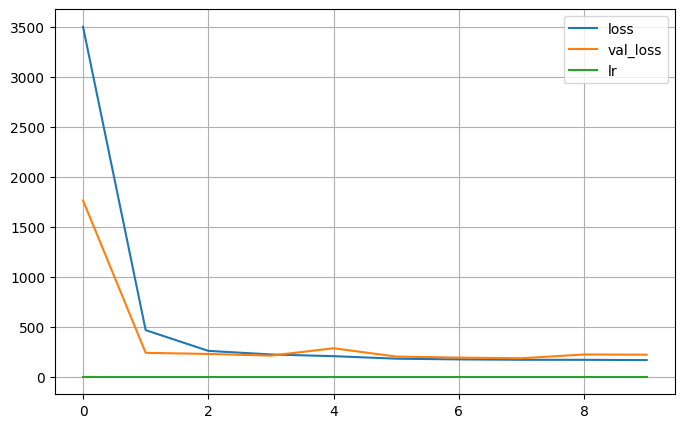

4/4 [==============================] - 0s 7ms/step
test_rmse 14.690516
Experiment 2/12...
all_columns LSTM 24
['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
Train Sequence Shape:  (17631, 30, 24)
Train Sequence Labels:  (17631, 1)
Test Sequence Shape:  (100, 30, 24)

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
124/124 [==============================] - 24s 135ms/step - loss: 3458.3601 - val_loss: 1757.2675 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
124/124 [==============================] - 16s 126ms/step - loss: 1744.6182 - val_loss: 1767.9702 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
124/124 [==============================] - 16s 125ms/step - loss: 1123.0360 - val_loss: 268.0817 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning

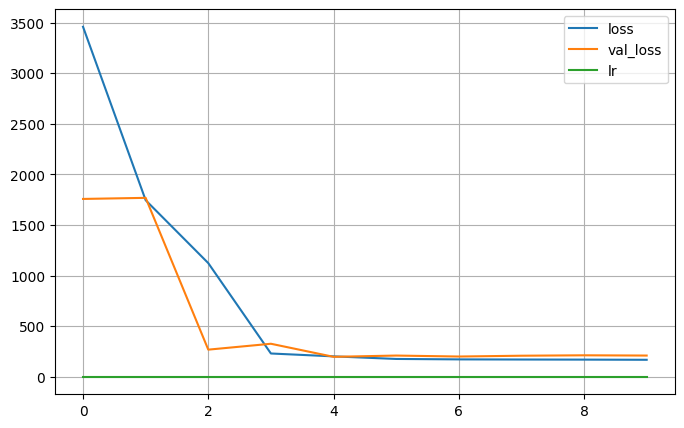

4/4 [==============================] - 0s 22ms/step
test_rmse 14.664589
Experiment 3/12...
all_columns BIDIRECTIONAL 24
['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
Train Sequence Shape:  (17631, 30, 24)
Train Sequence Labels:  (17631, 1)
Test Sequence Shape:  (100, 30, 24)

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
124/124 [==============================] - 48s 285ms/step - loss: 3241.0581 - val_loss: 679.8938 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
124/124 [==============================] - 34s 271ms/step - loss: 606.9904 - val_loss: 405.8732 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
124/124 [==============================] - 32s 261ms/step - loss: 319.7796 - val_loss: 280.0725 - lr: 0.0010

Epoch 4: LearningRateScheduler setting le

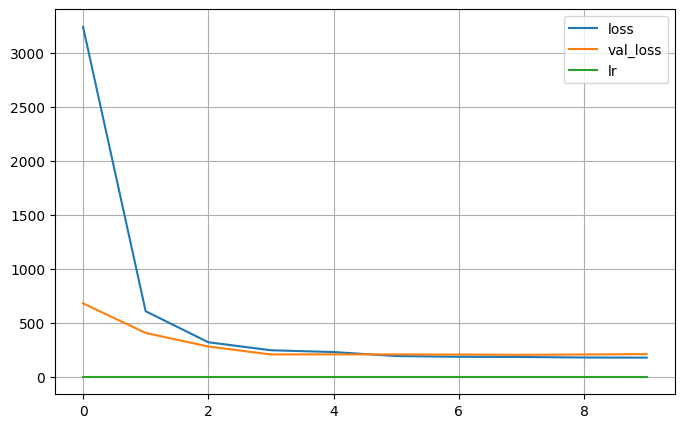

4/4 [==============================] - 0s 24ms/step
test_rmse 15.005487
Experiment 4/12...
all_columns GRU 24
['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
Train Sequence Shape:  (17631, 30, 24)
Train Sequence Labels:  (17631, 1)
Test Sequence Shape:  (100, 30, 24)

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
124/124 [==============================] - 20s 109ms/step - loss: 3456.0261 - val_loss: 1757.0388 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
124/124 [==============================] - 13s 101ms/step - loss: 1745.0273 - val_loss: 1779.0791 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
124/124 [==============================] - 13s 103ms/step - loss: 620.6418 - val_loss: 220.5219 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning 

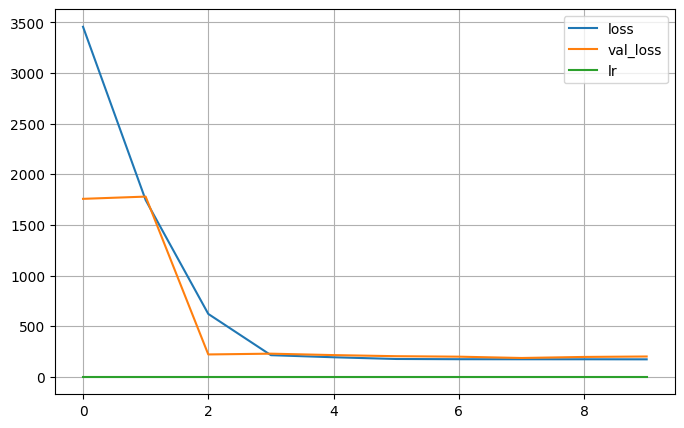

4/4 [==============================] - 0s 11ms/step
test_rmse 14.978274
Experiment 5/12...
without_settings RNN 21
['s16', 's3', 's9', 's18', 's7', 's1', 's5', 's19', 's17', 's4', 's15', 's21', 's11', 's20', 's13', 's12', 's14', 's6', 's10', 's2', 's8']
Train Sequence Shape:  (17631, 30, 21)
Train Sequence Labels:  (17631, 1)
Test Sequence Shape:  (100, 30, 21)

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
124/124 [==============================] - 8s 41ms/step - loss: 3682.2661 - val_loss: 1769.2565 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
124/124 [==============================] - 5s 43ms/step - loss: 799.1466 - val_loss: 432.1989 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
124/124 [==============================] - 5s 37ms/step - loss: 343.7448 - val_loss: 273.1533 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
124/124 [====

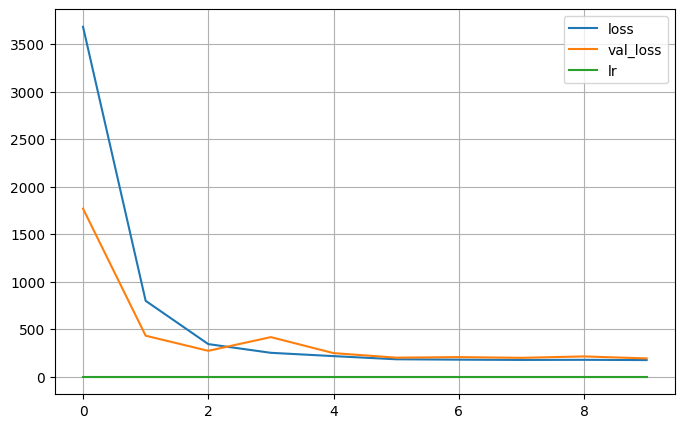

4/4 [==============================] - 0s 7ms/step
test_rmse 14.815945
Experiment 6/12...
without_settings LSTM 21
['s16', 's3', 's9', 's18', 's7', 's1', 's5', 's19', 's17', 's4', 's15', 's21', 's11', 's20', 's13', 's12', 's14', 's6', 's10', 's2', 's8']
Train Sequence Shape:  (17631, 30, 21)
Train Sequence Labels:  (17631, 1)
Test Sequence Shape:  (100, 30, 21)

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
124/124 [==============================] - 23s 134ms/step - loss: 3244.1582 - val_loss: 1765.6130 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
124/124 [==============================] - 16s 129ms/step - loss: 1745.0424 - val_loss: 1795.5160 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
124/124 [==============================] - 16s 126ms/step - loss: 1709.3541 - val_loss: 994.4281 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
124/

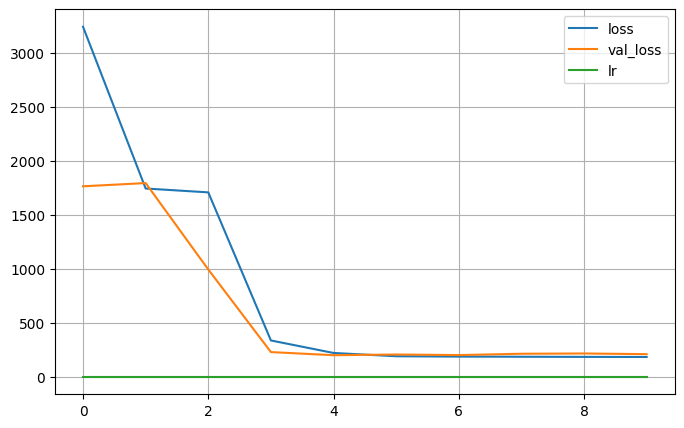

4/4 [==============================] - 0s 15ms/step
test_rmse 15.21326
Experiment 7/12...
without_settings BIDIRECTIONAL 21
['s16', 's3', 's9', 's18', 's7', 's1', 's5', 's19', 's17', 's4', 's15', 's21', 's11', 's20', 's13', 's12', 's14', 's6', 's10', 's2', 's8']
Train Sequence Shape:  (17631, 30, 21)
Train Sequence Labels:  (17631, 1)
Test Sequence Shape:  (100, 30, 21)

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
124/124 [==============================] - 48s 289ms/step - loss: 2533.7739 - val_loss: 646.8090 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
124/124 [==============================] - 35s 279ms/step - loss: 478.6432 - val_loss: 435.2401 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
124/124 [==============================] - 33s 265ms/step - loss: 381.9633 - val_loss: 315.6348 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10

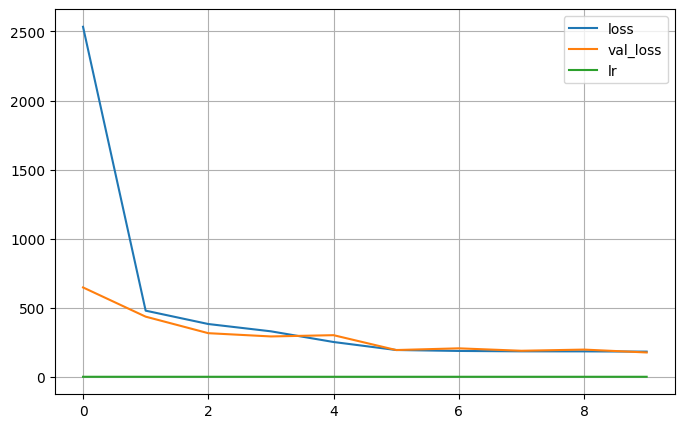

4/4 [==============================] - 0s 23ms/step
test_rmse 14.951957
Experiment 8/12...
without_settings GRU 21
['s16', 's3', 's9', 's18', 's7', 's1', 's5', 's19', 's17', 's4', 's15', 's21', 's11', 's20', 's13', 's12', 's14', 's6', 's10', 's2', 's8']
Train Sequence Shape:  (17631, 30, 21)
Train Sequence Labels:  (17631, 1)
Test Sequence Shape:  (100, 30, 21)

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
124/124 [==============================] - 21s 114ms/step - loss: 3787.8818 - val_loss: 1794.1594 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
124/124 [==============================] - 13s 105ms/step - loss: 1745.9114 - val_loss: 1776.9871 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
124/124 [==============================] - 13s 101ms/step - loss: 993.9891 - val_loss: 296.6486 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
124/1

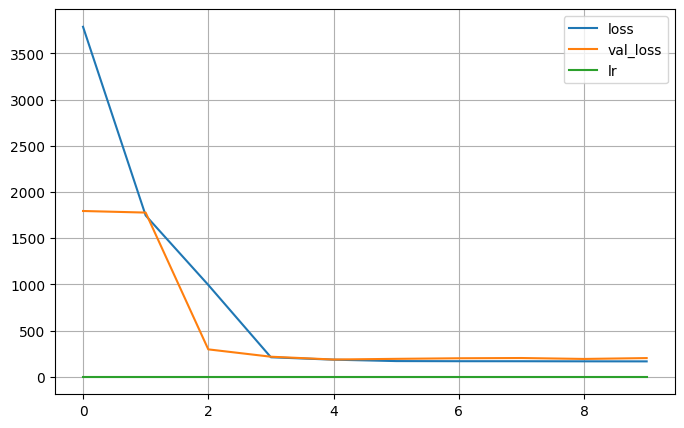

4/4 [==============================] - 0s 11ms/step
test_rmse 14.843093
Experiment 9/12...
without_constant_sensors RNN 14
['s13', 's4', 's15', 's21', 's3', 's12', 's9', 's14', 's2', 's11', 's20', 's8', 's7', 's17']
Train Sequence Shape:  (17631, 30, 14)
Train Sequence Labels:  (17631, 1)
Test Sequence Shape:  (100, 30, 14)

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
124/124 [==============================] - 8s 45ms/step - loss: 3090.8765 - val_loss: 445.9964 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
124/124 [==============================] - 5s 39ms/step - loss: 382.6005 - val_loss: 324.5221 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
124/124 [==============================] - 5s 37ms/step - loss: 319.7862 - val_loss: 548.2634 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
124/124 [==============================] - 5s 39ms/s

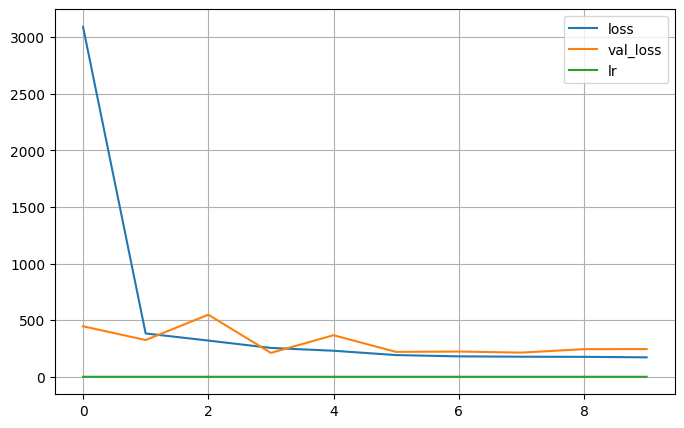

4/4 [==============================] - 0s 7ms/step
test_rmse 14.727403
Experiment 10/12...
without_constant_sensors LSTM 14
['s13', 's4', 's15', 's21', 's3', 's12', 's9', 's14', 's2', 's11', 's20', 's8', 's7', 's17']
Train Sequence Shape:  (17631, 30, 14)
Train Sequence Labels:  (17631, 1)
Test Sequence Shape:  (100, 30, 14)

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
124/124 [==============================] - 23s 135ms/step - loss: 3257.8152 - val_loss: 365.3675 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
124/124 [==============================] - 16s 128ms/step - loss: 276.4032 - val_loss: 220.4230 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
124/124 [==============================] - 15s 124ms/step - loss: 218.1000 - val_loss: 222.4343 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
124/124 [==============================] - 16

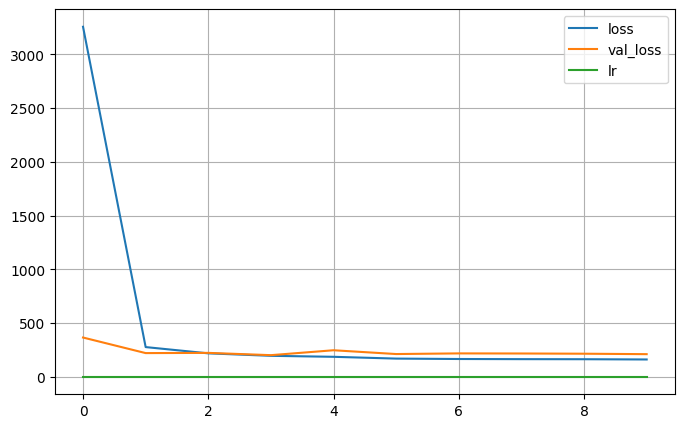

4/4 [==============================] - 0s 15ms/step
test_rmse 15.184762
Experiment 11/12...
without_constant_sensors BIDIRECTIONAL 14
['s13', 's4', 's15', 's21', 's3', 's12', 's9', 's14', 's2', 's11', 's20', 's8', 's7', 's17']
Train Sequence Shape:  (17631, 30, 14)
Train Sequence Labels:  (17631, 1)
Test Sequence Shape:  (100, 30, 14)

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
124/124 [==============================] - 48s 285ms/step - loss: 2096.3093 - val_loss: 312.9577 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
124/124 [==============================] - 33s 269ms/step - loss: 234.7527 - val_loss: 253.1395 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
124/124 [==============================] - 33s 264ms/step - loss: 214.6657 - val_loss: 244.9238 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
124/124 [==========================

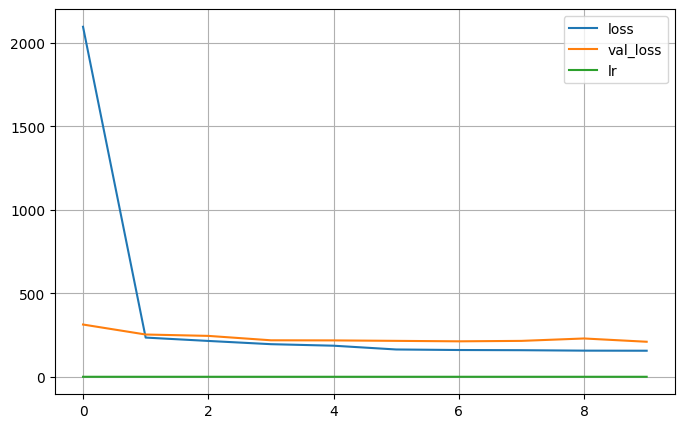

4/4 [==============================] - 0s 25ms/step
test_rmse 14.89378
Experiment 12/12...
without_constant_sensors GRU 14
['s13', 's4', 's15', 's21', 's3', 's12', 's9', 's14', 's2', 's11', 's20', 's8', 's7', 's17']
Train Sequence Shape:  (17631, 30, 14)
Train Sequence Labels:  (17631, 1)
Test Sequence Shape:  (100, 30, 14)

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
124/124 [==============================] - 23s 115ms/step - loss: 3443.4080 - val_loss: 1765.1743 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
124/124 [==============================] - 13s 102ms/step - loss: 1532.9241 - val_loss: 559.1361 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
124/124 [==============================] - 13s 102ms/step - loss: 312.9554 - val_loss: 295.1581 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
124/124 [==============================] - 1

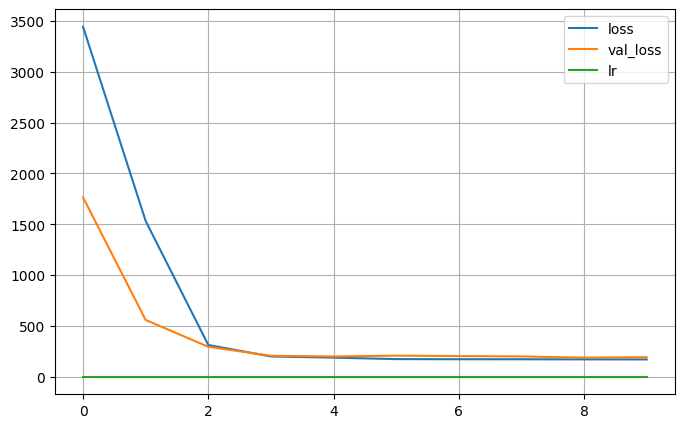

4/4 [==============================] - 0s 10ms/step
test_rmse 15.039395
CPU times: user 1h 24min 25s, sys: 21min 52s, total: 1h 46min 17s
Wall time: 37min 37s


In [17]:
%%time
counter=1;
for experiment in sequence_experiments:
    print(f'Experiment {counter}/{len(sequence_experiments)}...')
    counter+=1
    
    cols = experiment['include_columns']
    model_name = experiment['model_name']
    
    if(cols=='without_settings'):
        to_exclude.extend(label_cols)
        to_exclude.extend(settings_cols)
        sequence_cols = list(set(train_df.columns) - set(to_exclude))

    elif (cols=='without_constant_sensors'):
        to_exclude.extend(label_cols)
        to_exclude.extend(settings_cols)
        to_exclude.extend(constant_sensors)
        sequence_cols = list(set(train_df.columns) - set(to_exclude))
        
    
    # generator for the sequences
    seq_gen = (list(gen_sequence(train_df[train_df['unit']==unit], sequence_length, sequence_cols)) 
               for unit in train_df['unit'].unique())

    # generate sequences and convert to numpy array
    seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    
    # generate labels
    label_gen = [gen_labels(train_df[train_df['unit']==unit], sequence_length, ['RUL']) 
             for unit in train_df['unit'].unique()]

    # seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

    label_array = np.concatenate(list(label_gen)).astype(np.float32)
    # set the initial rul value to be 125 => we only consider wear after cycle 125
    label_array[label_array>125] = 125 
    
    seq_array_test_last = gen_test_sequence(test_df,sequence_length,sequence_cols)
    label_array_test_last = gen_test_labels(test_df,sequence_length)
    
    print(cols,model_name,len(sequence_cols))
    print(sequence_cols)
    print('Train Sequence Shape: ',seq_array.shape)
    print('Train Sequence Labels: ',label_array.shape)
    print('Test Sequence Shape: ',seq_array_test_last.shape)
     
    model = create_compiled_model(model_name,(sequence_length,len(sequence_cols)))
    
    callback = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
    history = model.fit(seq_array, # Training features
          label_array, # Training labels
          epochs=10,   # We'll stop after 10 epochs
          batch_size=128, # 
          validation_split=0.10, # Use 10% of data to evaluate the loss. (val_loss)
          verbose=1, #
          callbacks = callback)
    
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.show()
    
    experiment['model_instance'] = model
    # Evaluate the model on the training & test set
    
    train_predictions = model.predict(seq_array)
    test_predictions = model.predict(seq_array_test_last)

    train_mse,train_mae,train_rmse,train_r2 = evaluateModel(label_array,train_predictions)
    test_mse,test_mae,test_rmse,test_r2 = evaluateModel(label_array_test_last,test_predictions)
    print("test_rmse",test_rmse)
    experiment['train_rmse']=train_rmse
    experiment['test_rmse']=test_rmse
    
    experiment['train_mse']=train_mse
    experiment['test_mse']=test_mse
    
    experiment['train_mae']=train_mae
    experiment['test_mae']=test_mae
    
    experiment['train_r2']=train_r2
    experiment['test_r2']=test_r2    
    
    
    

In [103]:
# # Data
# dt = {
#     'Model Name': ['Decision Tree', 'LSTM', 'CNN'],
#     'Test RMSE': [46.420696, 14.664589, 14.742612]
# }

# # Create DataFrame
# df1 = pd.DataFrame(dt)

# # Order by Test RMSE
# df1_sorted = df1.sort_values(by='Test RMSE')

# # Display the sorted DataFrame
# df1_sorted

In [18]:
sequence_experiments_df = pd.DataFrame(sequence_experiments)
sorted_sequence_experiments_df = sequence_experiments_df.sort_values(by=['train_rmse','test_rmse','test_r2'])
sorted_sequence_experiments_df = sorted_sequence_experiments_df.reset_index(drop=True)
sorted_sequence_experiments_df

,include_columns,model_name,model_instance,train_rmse,test_rmse,train_mse,test_mse,train_mae,test_mae,train_r2,test_r2
0,without_constant_sensors,BIDIRECTIONAL,<keras.src.engine.sequential.Sequential object...,12.596486,14.893780,158.671463,221.824661,9.048241,11.105224,0.909142,0.871545
1,without_constant_sensors,LSTM,<keras.src.engine.sequential.Sequential object...,12.814702,15.184762,164.216599,230.577011,9.245261,11.471929,0.905966,0.866477
2,without_settings,GRU,<keras.src.engine.sequential.Sequential object...,13.027310,14.843093,169.710815,220.317398,9.377484,10.967306,0.902820,0.872418
3,all_columns,LSTM,<keras.src.engine.sequential.Sequential object...,13.035084,14.664589,169.913406,215.050156,9.536665,10.821207,0.902704,0.875468
4,all_columns,RNN,<keras.src.engine.sequential.Sequential object...,13.077852,14.690516,171.030212,215.811264,9.441519,10.472330,0.902065,0.875027
5,without_constant_sensors,GRU,<keras.src.engine.sequential.Sequential object...,13.129548,15.039395,172.385040,226.183411,9.355967,11.009736,0.901289,0.869021
6,all_columns,GRU,<keras.src.engine.sequential.Sequential object...,13.162667,14.978274,173.255814,224.348709,9.446178,11.053257,0.900790,0.870084
7,without_settings,RNN,<keras.src.engine.sequential.Sequential object...,13.201632,14.815945,174.283112,219.512207,9.561149,11.087503,0.900202,0.872884
8,all_columns,BIDIRECTIONAL,<keras.src.engine.sequential.Sequential object...,13.279197,15.005487,176.337067,225.164642,9.622453,10.791264,0.899026,0.869611
9,without_constant_sensors,RNN,<keras.src.engine.sequential.Sequential object...,13.407561,14.727403,179.762695,216.896393,9.718026,10.437422,0.897064,0.874399


In [105]:
sorted_sequence_experiments_df[sorted_sequence_experiments_df['include_columns']=='all_columns']

,include_columns,model_name,model_instance,train_rmse,test_rmse,train_mse,test_mse,train_mae,test_mae,train_r2,test_r2
3,all_columns,LSTM,<keras.src.engine.sequential.Sequential object...,13.035084,14.664589,169.913406,215.050156,9.536665,10.821207,0.902704,0.875468
4,all_columns,RNN,<keras.src.engine.sequential.Sequential object...,13.077852,14.690516,171.030212,215.811264,9.441519,10.472330,0.902065,0.875027
6,all_columns,GRU,<keras.src.engine.sequential.Sequential object...,13.162667,14.978274,173.255814,224.348709,9.446178,11.053257,0.900790,0.870084
8,all_columns,BIDIRECTIONAL,<keras.src.engine.sequential.Sequential object...,13.279197,15.005487,176.337067,225.164642,9.622453,10.791264,0.899026,0.869611


## Save the best Model so far: - Bidirectional

In [20]:
sorted_sequence_experiments_df.loc[:0]

,include_columns,model_name,model_instance,train_rmse,test_rmse,train_mse,test_mse,train_mae,test_mae,train_r2,test_r2
0,without_constant_sensors,BIDIRECTIONAL,<keras.src.engine.sequential.Sequential object...,12.596486,14.89378,158.671463,221.824661,9.048241,11.105224,0.909142,0.871545


In [21]:
sorted_sequence_experiments_df.loc[:0]['model_instance'].values[0].save("birectional_best.h5")

## Investigate the effect of sequence length - make this code reusable

In [22]:
sequence_length = 50

In [23]:
model_names = ['RNN','LSTM','BIDIRECTIONAL','GRU']

sequence_experiments2 = []
for dataset in dataset_variations[0:1]:
    for model in model_names:
        sequence_experiments2.append({'include_columns': dataset, 'model_name': model})

Experiment 1/12...
all_columns RNN 24
['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
Train Sequence Shape:  (15631, 50, 24)
Train Sequence Labels:  (15631, 1)
Test Sequence Shape:  (93, 50, 24)

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
110/110 [==============================] - 12s 72ms/step - loss: 3484.6917 - val_loss: 1786.6235 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
110/110 [==============================] - 7s 66ms/step - loss: 1185.8639 - val_loss: 466.8574 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
110/110 [==============================] - 7s 62ms/step - loss: 406.2585 - val_loss: 376.9875 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
110/110 [==============================] - 7s 66ms/st

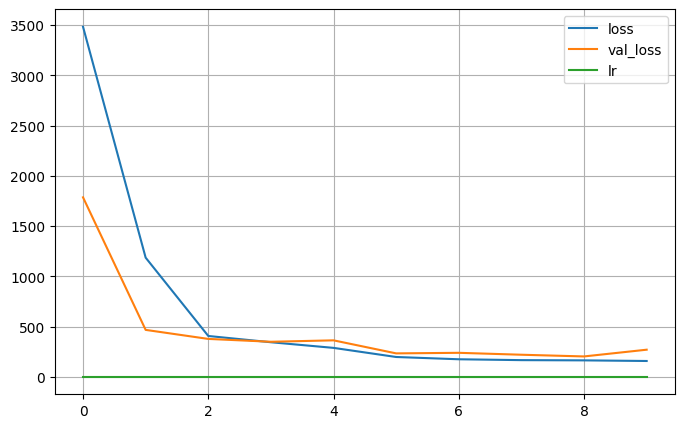

3/3 [==============================] - 0s 10ms/step
test_rmse 15.683984
Experiment 2/12...
all_columns LSTM 24
['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
Train Sequence Shape:  (15631, 50, 24)
Train Sequence Labels:  (15631, 1)
Test Sequence Shape:  (93, 50, 24)

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
110/110 [==============================] - 34s 250ms/step - loss: 3527.8499 - val_loss: 1790.1434 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
110/110 [==============================] - 27s 245ms/step - loss: 1703.6432 - val_loss: 1824.0900 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
110/110 [==============================] - 27s 246ms/step - loss: 1682.8232 - val_loss: 1334.2825 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learnin

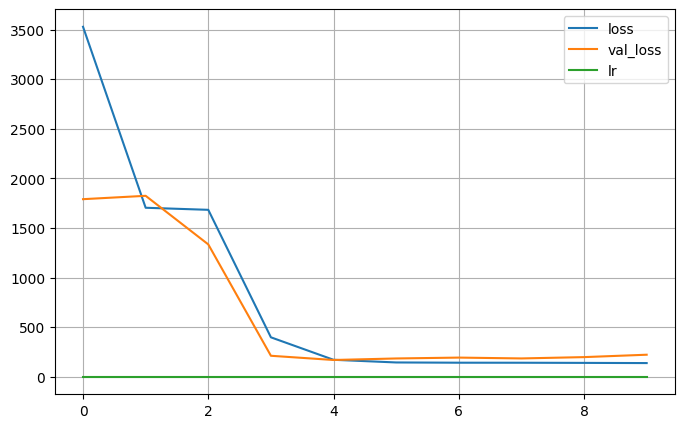

3/3 [==============================] - 0s 33ms/step
test_rmse 15.879118
Experiment 3/12...
all_columns BIDIRECTIONAL 24
['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
Train Sequence Shape:  (15631, 50, 24)
Train Sequence Labels:  (15631, 1)
Test Sequence Shape:  (93, 50, 24)

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
110/110 [==============================] - 73s 523ms/step - loss: 3101.9429 - val_loss: 1769.0656 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
110/110 [==============================] - 49s 442ms/step - loss: 1706.4678 - val_loss: 1828.7148 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
110/110 [==============================] - 49s 445ms/step - loss: 1106.8246 - val_loss: 396.7443 - lr: 0.0010

Epoch 4: LearningRateScheduler setting

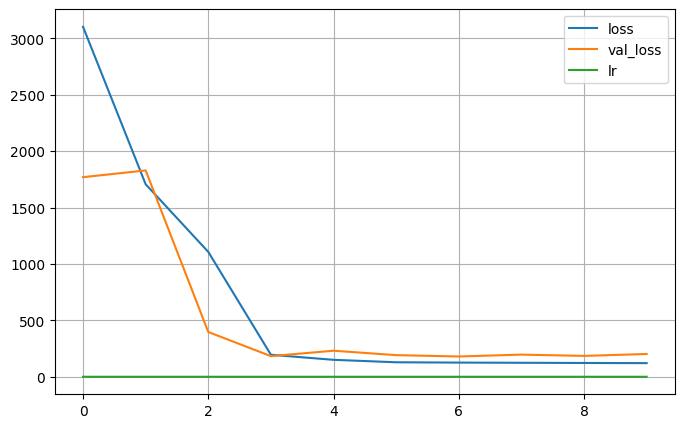

3/3 [==============================] - 0s 44ms/step
test_rmse 14.86933
Experiment 4/12...
all_columns GRU 24
['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
Train Sequence Shape:  (15631, 50, 24)
Train Sequence Labels:  (15631, 1)
Test Sequence Shape:  (93, 50, 24)

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
110/110 [==============================] - 31s 206ms/step - loss: 3537.4177 - val_loss: 1791.1445 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
110/110 [==============================] - 22s 199ms/step - loss: 1704.2505 - val_loss: 1785.6125 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
110/110 [==============================] - 19s 173ms/step - loss: 1214.9006 - val_loss: 405.4100 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning r

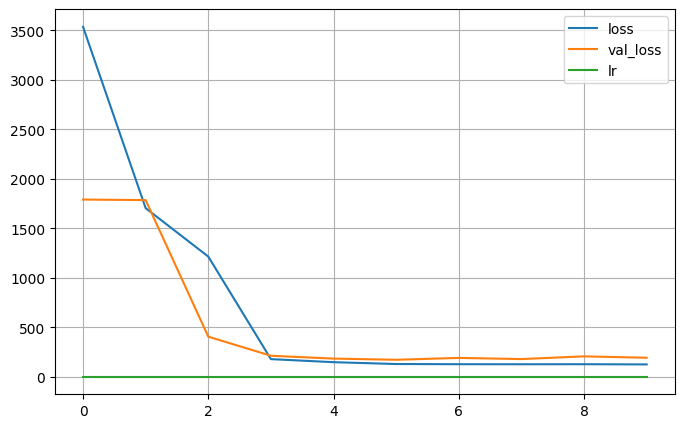

3/3 [==============================] - 0s 19ms/step
test_rmse 15.301509
CPU times: user 41min 9s, sys: 10min 21s, total: 51min 31s
Wall time: 18min 54s


In [24]:
%%time

# target_column = ['RUL']
to_exclude = ['unit','cycle','cycle_norm']
settings_cols = ['setting1','setting2','setting3']
constant_sensors = ['s1','s5','s6','s10','s16','s18','s19']

sequence_cols = ['setting1', 'setting2', 'setting3']
key_cols = ['unit', 'cycle']
label_cols = ['label1', 'label2', 'RUL']

input_features = train_df.columns.values.tolist()
sensor_cols = [x for x in input_features if x not in set(key_cols)]
sensor_cols = [x for x in sensor_cols if x not in set(label_cols)]
sensor_cols = [x for x in sensor_cols if x not in set(sequence_cols)]
sensor_cols = [x for x in sensor_cols if x not in set(to_exclude)]


# The time is sequenced along
# This may be a silly way to get these column names, but it's relatively clear
sequence_cols.extend(sensor_cols)

counter=1;
for experiment in sequence_experiments2:
    print(f'Experiment {counter}/{len(sequence_experiments)}...')
    counter+=1
    
    cols = experiment['include_columns']
    model_name = experiment['model_name']
    
    if(cols=='without_settings'):
        to_exclude.extend(label_cols)
        to_exclude.extend(settings_cols)
        sequence_cols = list(set(train_df.columns) - set(to_exclude))

    elif (cols=='without_constant_sensors'):
        to_exclude.extend(label_cols)
        to_exclude.extend(settings_cols)
        to_exclude.extend(constant_sensors)
        sequence_cols = list(set(train_df.columns) - set(to_exclude))
        
    
    # generator for the sequences
    seq_gen = (list(gen_sequence(train_df[train_df['unit']==unit], sequence_length, sequence_cols)) 
               for unit in train_df['unit'].unique())

    # generate sequences and convert to numpy array
    seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    
    # generate labels
    label_gen = [gen_labels(train_df[train_df['unit']==unit], sequence_length, ['RUL']) 
             for unit in train_df['unit'].unique()]

    # seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

    label_array = np.concatenate(list(label_gen)).astype(np.float32)
    # set the initial rul value to be 125 => we only consider wear after cycle 125
    label_array[label_array>125] = 125 
    
    seq_array_test_last = gen_test_sequence(test_df,sequence_length,sequence_cols)
    label_array_test_last = gen_test_labels(test_df,sequence_length)
    
    print(cols,model_name,len(sequence_cols))
    print(sequence_cols)
    print('Train Sequence Shape: ',seq_array.shape)
    print('Train Sequence Labels: ',label_array.shape)
    print('Test Sequence Shape: ',seq_array_test_last.shape)
     
    model = create_compiled_model(model_name,(sequence_length,len(sequence_cols)))
    
    callback = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
    history = model.fit(seq_array, # Training features
          label_array, # Training labels
          epochs=10,   # We'll stop after 10 epochs
          batch_size=128, # 
          validation_split=0.10, # Use 10% of data to evaluate the loss. (val_loss)
          verbose=1, #
          callbacks = callback)
    
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.show()
    
    experiment['model_instance'] = model
    # Evaluate the model on the training & test set
    
    train_predictions = model.predict(seq_array)
    test_predictions = model.predict(seq_array_test_last)

    train_mse,train_mae,train_rmse,train_r2 = evaluateModel(label_array,train_predictions)
    test_mse,test_mae,test_rmse,test_r2 = evaluateModel(label_array_test_last,test_predictions)
    print("test_rmse",test_rmse)
    experiment['train_rmse']=train_rmse
    experiment['test_rmse']=test_rmse
    
    experiment['train_mse']=train_mse
    experiment['test_mse']=test_mse
    
    experiment['train_mae']=train_mae
    experiment['test_mae']=test_mae
    
    experiment['train_r2']=train_r2
    experiment['test_r2']=test_r2    
    
    
    

In [25]:
sequence_experiments2_df = pd.DataFrame(sequence_experiments2)
sorted_sequence_experiments2_df = sequence_experiments2_df.sort_values(by=['train_rmse','test_rmse','test_r2'])
sorted_sequence_experiments2_df = sorted_sequence_experiments2_df.reset_index(drop=True)
sorted_sequence_experiments2_df

,include_columns,model_name,model_instance,train_rmse,test_rmse,train_mse,test_mse,train_mae,test_mae,train_r2,test_r2
0,all_columns,BIDIRECTIONAL,<keras.src.engine.sequential.Sequential object...,11.380941,14.869330,129.525818,221.097000,8.174997,11.222914,0.924278,0.868658
1,all_columns,GRU,<keras.src.engine.sequential.Sequential object...,11.443184,15.301509,130.946457,234.136169,8.255958,11.220110,0.923447,0.860912
2,all_columns,LSTM,<keras.src.engine.sequential.Sequential object...,12.138707,15.879118,147.348221,252.146393,8.868563,11.703318,0.913859,0.850213
3,all_columns,RNN,<keras.src.engine.sequential.Sequential object...,13.313599,15.683984,177.251907,245.987335,9.878529,11.072486,0.896377,0.853872


## TODO:
- 1D
- 2D  CNN architectures
- Try out the best architectures from the model


In [26]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['unit']==unit], sequence_length, sequence_cols)) 
           for unit in train_df['unit'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

# generate labels
label_gen = [gen_labels(train_df[train_df['unit']==unit], sequence_length, ['RUL']) 
         for unit in train_df['unit'].unique()]

# seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

label_array = np.concatenate(list(label_gen)).astype(np.float32)
# set the initial rul value to be 125 => we only consider wear after cycle 125
label_array[label_array>125] = 125 

seq_array_test_last = gen_test_sequence(test_df,sequence_length,sequence_cols)
label_array_test_last = gen_test_labels(test_df,sequence_length)


In [27]:
def getCNNMOdels(): 
    input_shape = (sequence_length, seq_array.shape[2])
    model1 = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2), 
        Flatten(), 
        Dense(50,activation='relu'), 
        Dense(1)
    ])
    
    model2 = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape), 
        MaxPooling1D(pool_size=2), 
        Conv1D(64, kernel_size=3, activation='relu'), 
        MaxPooling1D(pool_size=2), 
        Flatten(), 
        Dense(128, activation='relu'), 
        Dense(1)        
    ])
    
    model3 = Sequential([
        Conv1D(64, kernel_size=2, activation='relu', padding='valid', input_shape=input_shape), 
        MaxPooling1D(pool_size=2), 
        LSTM(100, activation='relu', return_sequences=True),
        LSTM(100, activation='relu'),
        Dense(1)
    ])
    
    return [model1,model2,model3]
    

In [28]:
cnn_models = getCNNMOdels()
count=1;
cnn_experiments = []
for dataset in dataset_variations[0:1]:
    for model in cnn_models:
        cnn_experiments.append({'include_columns': dataset, 'model_name': 'cnn_'+str(count)})
        count+=1

In [29]:
# cnn_experiments

Model 1/3

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
110/110 [==============================] - 2s 10ms/step - loss: 1499.2510 - val_loss: 725.1318 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
110/110 [==============================] - 1s 8ms/step - loss: 510.6747 - val_loss: 486.0252 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
110/110 [==============================] - 1s 8ms/step - loss: 293.0995 - val_loss: 252.8900 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
110/110 [==============================] - 1s 8ms/step - loss: 190.1126 - val_loss: 223.9482 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
110/110 [==============================] - 1s 8ms/step - loss: 165.0743 - val_loss: 204.0451 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6/10
110/110

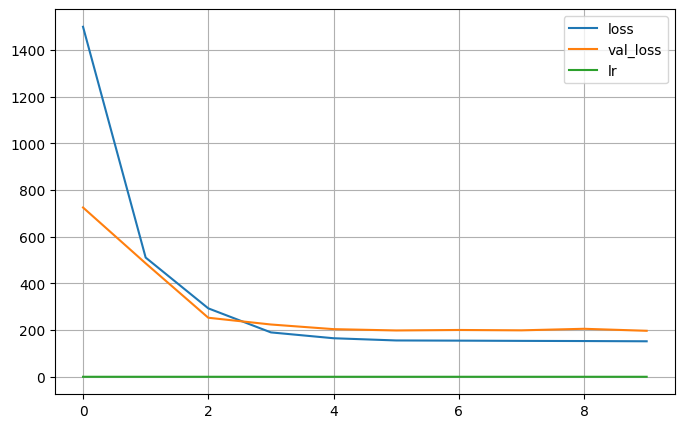

3/3 [==============================] - 0s 3ms/step
test_rmse 14.788995
Model 2/3

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
110/110 [==============================] - 2s 14ms/step - loss: 1465.9808 - val_loss: 669.1474 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
110/110 [==============================] - 1s 12ms/step - loss: 436.3520 - val_loss: 308.4039 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
110/110 [==============================] - 1s 13ms/step - loss: 202.5480 - val_loss: 198.2001 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
110/110 [==============================] - 1s 12ms/step - loss: 185.5951 - val_loss: 203.3952 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
110/110 [==============================] - 2s 14ms/step - loss: 163.3589 - val_loss: 191.7189 - lr: 0.0010

Epoch 6

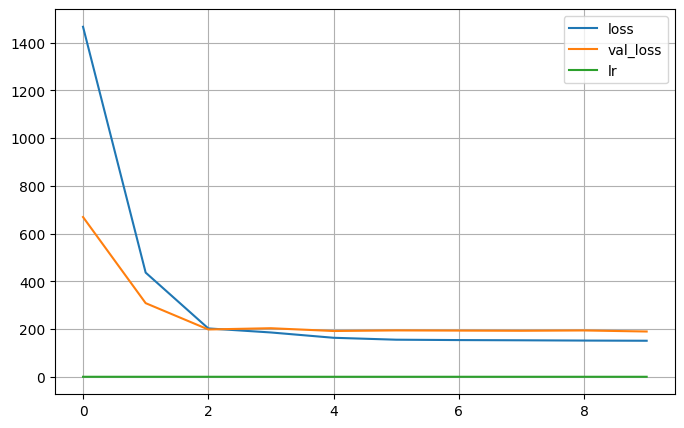

3/3 [==============================] - 0s 3ms/step
test_rmse 14.742612
Model 3/3

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
110/110 [==============================] - 14s 102ms/step - loss: 1471.5294 - val_loss: 530.1549 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
110/110 [==============================] - 11s 102ms/step - loss: 455.6023 - val_loss: 245.8428 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
110/110 [==============================] - 11s 103ms/step - loss: 260.0958 - val_loss: 284.5209 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
110/110 [==============================] - 12s 106ms/step - loss: 227.3229 - val_loss: 193.4222 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
110/110 [==============================] - 11s 103ms/step - loss: 178.3022 - val_loss: 267.4488 - lr: 0.001

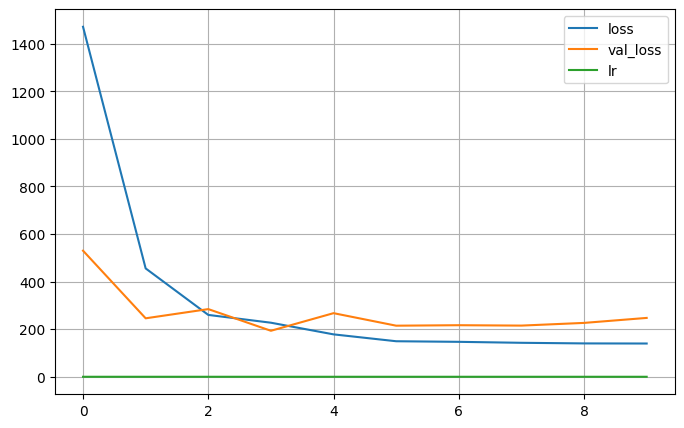

3/3 [==============================] - 0s 11ms/step
test_rmse 15.530972


In [30]:
count=0;
cnn_models = getCNNMOdels()
for experiment in cnn_experiments:
    print(f'Model {count+1}/{len(cnn_models)}')
    model = cnn_models[count]
    model.compile(loss = "mse", optimizer = keras.optimizers.Adam(learning_rate=0.001))
    
#     history = model.fit(seq_array, label_array, epochs=10, verbose=1,validation_split=0.1)
    callback = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
    history = model.fit(seq_array, # Training features
          label_array, # Training labels
          epochs=10,   # We'll stop after 10 epochs
          batch_size=128, # 
          validation_split=0.10, # Use 10% of data to evaluate the loss. (val_loss)
          verbose=1, #
          callbacks = callback)
    
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.show()
    
    experiment['model_instance'] = model
    # Evaluate the model on the training & test set
    
    train_predictions = model.predict(seq_array)
    test_predictions = model.predict(seq_array_test_last)

    train_mse,train_mae,train_rmse,train_r2 = evaluateModel(label_array,train_predictions)
    test_mse,test_mae,test_rmse,test_r2 = evaluateModel(label_array_test_last,test_predictions)
    print("test_rmse",test_rmse)
    experiment['train_rmse']=train_rmse
    experiment['test_rmse']=test_rmse
    
    experiment['train_mse']=train_mse
    experiment['test_mse']=test_mse
    
    experiment['train_mae']=train_mae
    experiment['test_mae']=test_mae
    
    experiment['train_r2']=train_r2
    experiment['test_r2']=test_r2  
    
    count+=1
    

In [31]:
cnn_experiments_df = pd.DataFrame(cnn_experiments)
sorted_cnn_experiments_df = cnn_experiments_df.sort_values(by=['train_rmse','test_rmse','test_r2'])
sorted_cnn_experiments_df = sorted_cnn_experiments_df.reset_index(drop=True)
sorted_cnn_experiments_df

,include_columns,model_name,model_instance,train_rmse,test_rmse,train_mse,test_mse,train_mae,test_mae,train_r2,test_r2
0,all_columns,cnn_2,<keras.src.engine.sequential.Sequential object...,12.407845,14.742612,153.954605,217.344604,9.506860,10.951596,0.909997,0.870887
1,all_columns,cnn_1,<keras.src.engine.sequential.Sequential object...,12.500156,14.788995,156.253906,218.714355,9.661545,10.657921,0.908652,0.870073
2,all_columns,cnn_3,<keras.src.engine.sequential.Sequential object...,12.532536,15.530972,157.064453,241.211090,9.456676,11.401534,0.908179,0.856709


## Trying Wavenet 

In [42]:
input_shape = (sequence_length, seq_array.shape[2])
model2 = Sequential([
        Conv1D(filters=128,kernel_size=2, input_shape=input_shape, padding="causal", activation="relu", dilation_rate=1),
        Conv1D(filters=64, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
        Conv1D(filters=32, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
        Conv1D(filters=32, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
        Conv1D(filters=32, kernel_size=2, padding="causal", activation="relu", dilation_rate=1),
        Conv1D(filters=32, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
        Conv1D(filters=32, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
        Conv1D(filters=32, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
        Conv1D(filters=32, kernel_size=2, padding="causal", activation="relu", dilation_rate=1),
        Conv1D(filters=32, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
        Conv1D(filters=32, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
        Conv1D(filters=32, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
        Conv1D(filters=10, kernel_size=1, activation="relu"),
        Dense(96, activation="relu"),
        Dense(128, activation="relu"),
        Dense(1)
    ])
model2.compile(loss = "mse", optimizer = keras.optimizers.Adam(learning_rate=0.001))


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
110/110 [==============================] - 25s 179ms/step - loss: 2339.8809 - val_loss: 817.0038 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
110/110 [==============================] - 16s 141ms/step - loss: 719.6018 - val_loss: 726.6040 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
110/110 [==============================] - 15s 132ms/step - loss: 634.9900 - val_loss: 674.7327 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
110/110 [==============================] - 14s 123ms/step - loss: 558.3859 - val_loss: 654.3920 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
110/110 [==============================] - 14s 130ms/step - loss: 528.7012 - val_loss: 517.1648 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6/10
110

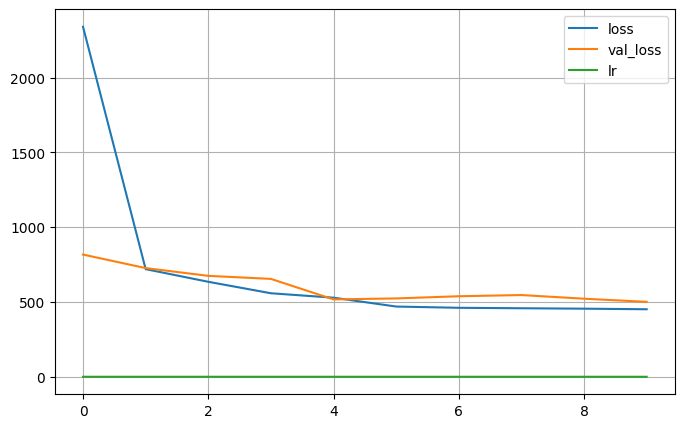

In [44]:
callback = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
history = model2.fit(seq_array, # Training features
      label_array, # Training labels
      epochs=10,   # We'll stop after 10 epochs
      batch_size=128, # 
      validation_split=0.10, # Use 10% of data to evaluate the loss. (val_loss)
      verbose=1, #
      callbacks = callback)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()


In [60]:
train_predictions = model2.predict(seq_array)
test_predictions = model2.predict(seq_array_test_last)

3/3 [==============================] - 0s 12ms/step


In [66]:
average_train_predictions = np.mean(train_predictions[:, :50, :], axis=1)
average_test_predictions = np.mean(test_predictions[:, :50, :], axis=1)
train_mse,train_mae,train_rmse,train_r2 = evaluateModel(label_array,average_train_predictions)
test_mse,test_mae,test_rmse,test_r2 = evaluateModel(label_array_test_last,average_test_predictions)
print("Train RMSE: ", train_rmse)
print("Test RMSE: ",test_rmse)

Train RMSE:  17.010323
Test RMSE:  19.669922


In [69]:
input_shape

(50, 24)

## Try 2D CNN


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20
110/110 [==============================] - 16s 122ms/step - loss: 1587.0585 - val_loss: 711.5352 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/20
110/110 [==============================] - 13s 119ms/step - loss: 524.0082 - val_loss: 419.1914 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/20
110/110 [==============================] - 13s 123ms/step - loss: 292.3087 - val_loss: 268.8736 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/20
110/110 [==============================] - 15s 134ms/step - loss: 206.9870 - val_loss: 226.1414 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/20
110/110 [==============================] - 15s 140ms/step - loss: 188.6596 - val_loss: 214.5368 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6/20
110

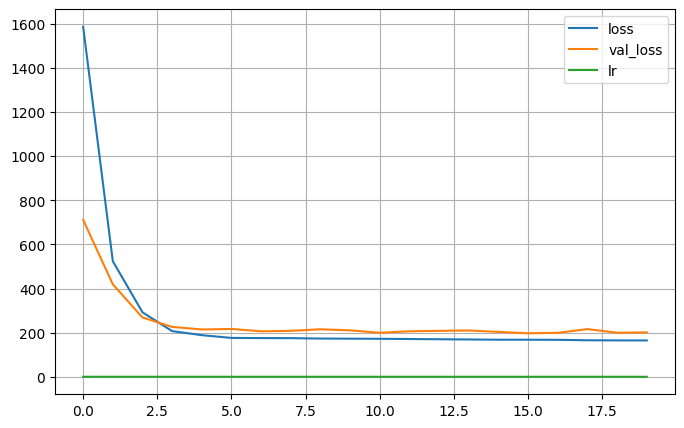

In [75]:
model3 = Sequential([
    Conv2D(32, kernel_size=3, activation='relu', input_shape=(50, 24, 1)), 
    MaxPooling2D(pool_size=(2, 2)),  # Use MaxPooling2D instead of MaxPooling1D
    Conv2D(64, kernel_size=3, activation='relu'), 
    MaxPooling2D(pool_size=(2, 2)), 
    Flatten(), 
    Dense(128, activation='relu'), 
    Dense(1)        
])

model3.compile(loss = "mse", optimizer = keras.optimizers.Adam(learning_rate=0.001))
callback = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
history = model3.fit(seq_array, # Training features
      label_array, # Training labels
      epochs=20,   # We'll stop after 10 epochs
      batch_size=128, # 
      validation_split=0.10, # Use 10% of data to evaluate the loss. (val_loss)
      verbose=1, #
      callbacks = callback)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()


In [76]:
train_predictions = model3.predict(seq_array)
test_predictions = model3.predict(seq_array_test_last)

3/3 [==============================] - 0s 11ms/step


In [77]:
train_mse,train_mae,train_rmse,train_r2 = evaluateModel(label_array,train_predictions)
test_mse,test_mae,test_rmse,test_r2 = evaluateModel(label_array_test_last,test_predictions)
print("Train RMSE: ", train_rmse)
print("Test RMSE: ",test_rmse)

Train RMSE:  12.907896
Test RMSE:  14.673107


## Try Lenet-5


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
110/110 [==============================] - 10s 65ms/step - loss: 2322.0945 - val_loss: 1299.5342 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
110/110 [==============================] - 6s 56ms/step - loss: 1117.6469 - val_loss: 1003.1234 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
110/110 [==============================] - 6s 53ms/step - loss: 718.1998 - val_loss: 637.7917 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
110/110 [==============================] - 6s 52ms/step - loss: 524.9550 - val_loss: 478.3316 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
110/110 [==============================] - 6s 57ms/step - loss: 370.2442 - val_loss: 417.5967 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6/10
110/110 [

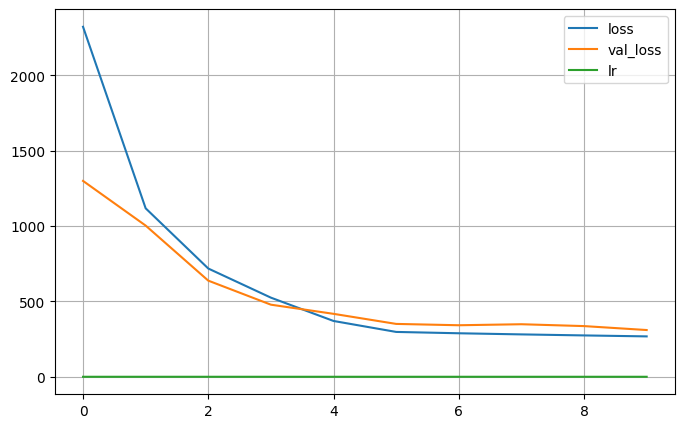

In [81]:
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense

model4 = Sequential([
    # Convolutional Layer 1
    Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(50, 24, 1)),
    
    # Subsampling (Pooling) Layer 1
    AveragePooling2D(pool_size=(2, 2)),
    
    # Convolutional Layer 2
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    
    # Subsampling (Pooling) Layer 2
    AveragePooling2D(pool_size=(2, 2)),
    
    # Flatten the previous layer output to feed into fully connected layers
    Flatten(),
    
    # Fully Connected Layer 1
    Dense(120, activation='relu'),
    
    # Fully Connected Layer 2
    Dense(84, activation='relu'),
    
    # Output layer with 10 units (assuming you have 10 classes for classification)
    Dense(1)
])

model4.compile(loss = "mse", optimizer = keras.optimizers.Adam(learning_rate=0.001))
callback = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
history = model4.fit(seq_array, # Training features
      label_array, # Training labels
      epochs=10,   # We'll stop after 10 epochs
      batch_size=128, # 
      validation_split=0.10, # Use 10% of data to evaluate the loss. (val_loss)
      verbose=1, #
      callbacks = callback)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()



In [82]:
train_predictions = model4.predict(seq_array)
test_predictions = model4.predict(seq_array_test_last)
train_mse,train_mae,train_rmse,train_r2 = evaluateModel(label_array,train_predictions)
test_mse,test_mae,test_rmse,test_r2 = evaluateModel(label_array_test_last,test_predictions)
print("Train RMSE: ", train_rmse)
print("Test RMSE: ",test_rmse)

3/3 [==============================] - 0s 7ms/step
Train RMSE:  16.469748
Test RMSE:  17.70995


In [106]:
seq_array.shape

(15631, 50, 24)

## Alex Net:


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
110/110 [==============================] - 112s 988ms/step - loss: 1664.4106 - val_loss: 434.9561 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
110/110 [==============================] - 108s 985ms/step - loss: 261.4145 - val_loss: 251.0037 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
110/110 [==============================] - 112s 1s/step - loss: 226.4250 - val_loss: 199.3427 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
110/110 [==============================] - 107s 972ms/step - loss: 203.4002 - val_loss: 317.0189 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
110/110 [==============================] - 104s 945ms/step - loss: 193.4352 - val_loss: 184.8325 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6/10
1

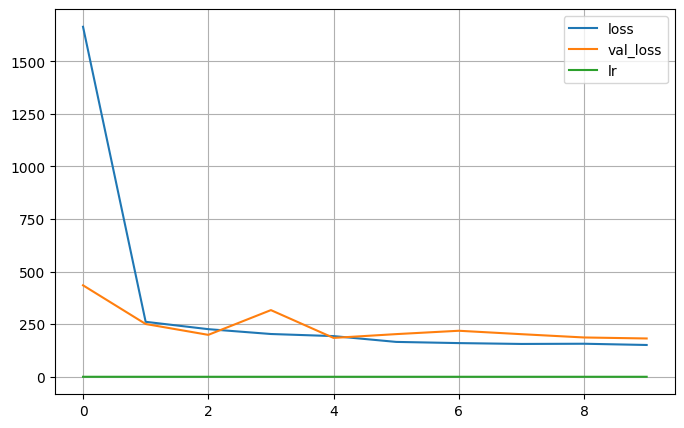

In [101]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model5 = Sequential([
    # Convolutional Layer 1
    Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(50, 24, 1)),
#     MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    # Convolutional Layer 2
#     Conv2D(256, kernel_size=(5, 5), activation='relu'),
#     MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    # Convolutional Layer 3
#     Conv2D(384, kernel_size=(3, 3), activation='relu'),
    
    # Convolutional Layer 4
#     Conv2D(384, kernel_size=(3, 3), activation='relu'),
    
    # Convolutional Layer 5
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
#     MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    # Flatten the previous layer output to feed into fully connected layers
    Flatten(),
    
    # Fully Connected Layer 1
    Dense(4096, activation='relu'),
    Dropout(0.5),
    
    # Fully Connected Layer 2
    Dense(4096, activation='relu'),
    Dropout(0.5),
    
    # Output layer with the number of units equal to the number of classes
    Dense(1)
])

model5.compile(loss = "mse", optimizer = keras.optimizers.Adam(learning_rate=0.001))
callback = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
history = model5.fit(seq_array, # Training features
      label_array, # Training labels
      epochs=10,   # We'll stop after 10 epochs
      batch_size=128, # 
      validation_split=0.10, # Use 10% of data to evaluate the loss. (val_loss)
      verbose=1, #
      callbacks = callback)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()


In [102]:
train_predictions = model5.predict(seq_array)
test_predictions = model5.predict(seq_array_test_last)
train_mse,train_mae,train_rmse,train_r2 = evaluateModel(label_array,train_predictions)
test_mse,test_mae,test_rmse,test_r2 = evaluateModel(label_array_test_last,test_predictions)
print("Train RMSE: ", train_rmse)
print("Test RMSE: ",test_rmse)

3/3 [==============================] - 0s 42ms/step
Train RMSE:  11.977244
Test RMSE:  14.071807
